In [220]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from currency_converter import CurrencyConverter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion, Pipeline


## Load & prepare data
1. Load Car4You dataset
2. Load Kaggle dataset: https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes?select=skoda.csv
3. Merge datasets

In [189]:
df_car4you_raw = pd.read_csv('./data/car4you_suv_all_final.csv', delimiter=';')
df_car4you_raw.head()

,web-scraper-order,web-scraper-start-url,price_raw,marke_modell_raw,baujahr_km_treibstoff_getriebe_raw,properties_raw,garage_raw,garage_place_raw,description_raw
0,1652200447-14927,https://www.carforyou.ch/de/auto/suv?page=1205,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1652197876-3840,https://www.carforyou.ch/de/auto/suv?page=1667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1652201197-18131,https://www.carforyou.ch/de/auto/suv?page=1071,CHF 80’500,Audi Q5 Sportback 45 TFSI Black Edition quattr...,2021 · 2’900 km · Elektro/Benzin · Automatik,pricecheckMarktpreis,NaN,NaN,NaN
3,1652197512-2221,https://www.carforyou.ch/de/auto/suv?page=1734,CHF 39’990,Audi Q2 35 TDI quattro S-tronic,2020 · 10’000 km · Diesel · Automatik,pricecheckÜber dem Marktpreis,NaN,NaN,[YS] schwarz - felsgrau[GB1] LTE-Unterstützung...
4,1652204391-31474,https://www.carforyou.ch/de/auto/suv?page=515,CHF 73’000,Jaguar E-Pace 2.0 I4 200 R-Dynamic Black AWD,2022 · 45 km · Elektro/Benzin · Automatik,pricecheckÜber dem MarktpreisumbrellaKäuferschutz,Emil Frey Zürich Altstetten,"8048 Zürich, Zürich",NaN


In [190]:
from typing import Dict
import re


def extract_regex(pattern: str, target: str) -> str:
    if not pd.isnull(target) and re.search(pattern, target):
        return re.findall(pattern, target)[0]
    return np.NaN


def extract_manufacturer(cell_content) -> str:
    if not pd.isnull(cell_content):
        return cell_content.split(' ')[0]
    return np.NaN


def extract_year(cell_content: str) -> int:
    year_str = extract_regex(r'[12][0-9]{3}', cell_content)
    return np.NaN if pd.isnull(year_str) else int(year_str)


def extract_km(cell_content: str) -> int:
    km_str = extract_regex(r'\d*’*\d+ km', cell_content)
    if pd.isnull(km_str):
        return np.NaN
    km = km_str.replace('’', '').replace(' km', '')
    return int(km)


def extract_fuel(cell_content: str) -> str:
    if "Elektro/Benzin" in cell_content or "Elektro/Diesel" in cell_content:
        return "Hybrid"
    if "Benzin" in cell_content:
        return "Petrol"
    if "Diesel" in cell_content:
        return "Diesel"
    if "Elektro" in cell_content:
        return "Electric"

    return np.NaN

def extract_transmission(cell_content: str) -> str:
    if "Automatik" in cell_content:
        return "Automatic"
    if "Manuell" in cell_content:
        return "Manual"
    return np.NaN

def extract_price(cell_content: str) -> str:
    if pd.isnull(cell_content):
        return np.NaN
    return str(cell_content).replace('CHF ', '').replace('’', '')

def extract_price_check(cell_content: str) -> str:
    if "Über dem Marktpreis" in cell_content:
        return "Above market"
    if "Unter dem Marktpreis" in cell_content:
        return "Below market"
    if "Marktpreis" in cell_content:
        return "Market"
    return np.NaN

def row_to_dict(row: pd.Series) -> Dict:
    row_dict = {
        'manufacturer': extract_manufacturer(row[3]),
        'year': extract_year(str(row[4])),
        'km': extract_km(str(row[4])),
        'fuel': extract_fuel(str(row[4])),
        'transmission': extract_transmission(str(row[4])),
        'price': extract_price(row[2]),
        'price_check': extract_price_check(str(row[5])),
    }

    return row_dict


In [191]:
data_raw = []
for index, row in df_car4you_raw.iterrows():
    data_raw.append(row_to_dict(row))

df_car4you = pd.DataFrame(data_raw)
df_car4you.head()

,manufacturer,year,km,fuel,transmission,price,price_check
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Audi,2021.0,2900.0,Hybrid,Automatic,80500,Market
3,Audi,2020.0,10000.0,Diesel,Automatic,39990,Above market
4,Jaguar,2022.0,45.0,Hybrid,Automatic,73000,Above market


In [192]:
curr_converter = CurrencyConverter('./data/eurofxref.csv')


def load_kaggle_dataset(path: str, manufacturer: str) -> pd.DataFrame:
    df_raw = pd.read_csv(path).drop(columns=['model', 'tax', 'tax(£)', 'mpg', 'engineSize'], errors='ignore')
    df_raw.insert(0, 'manufacturer', manufacturer)
    df_raw['price_check'] = 'Market'
    df_raw.price = df_raw.price.apply(lambda x: curr_converter.convert(x, 'GBP', 'CHF'))
    df_raw.mileage = df_raw.mileage * 1.61
    return df_raw.rename(columns={'mileage': 'km', 'fuelType': 'fuel'})

In [193]:
df_audi = load_kaggle_dataset('./data/audi.csv', 'Audi')
df_bmw = load_kaggle_dataset('./data/bmw.csv', 'BMW')
df_merc_c_class = load_kaggle_dataset('./data/cclass.csv', 'Mercedes-Benz')
df_merc = load_kaggle_dataset('./data/merc.csv', 'Mercedes-Benz')
df_ford_focus = load_kaggle_dataset('./data/focus.csv', 'Ford')
df_ford = load_kaggle_dataset('./data/ford.csv', 'Ford')
df_hyundai = load_kaggle_dataset('./data/hyundi.csv', 'Hyundai')
df_skoda = load_kaggle_dataset('./data/skoda.csv', 'Skoda')
df_toyota = load_kaggle_dataset('./data/toyota.csv', 'Toyota')
df_vauxhall = load_kaggle_dataset('./data/vauxhall.csv', 'Vauxhall')
df_vw = load_kaggle_dataset('./data/vw.csv', 'VW')

In [194]:
df_raw = pd.concat([df_car4you, df_audi, df_bmw, df_merc_c_class, df_merc, df_ford_focus, df_ford, df_hyundai, df_skoda, df_toyota, df_vauxhall, df_vw])
df_raw.head()

,manufacturer,year,km,fuel,transmission,price,price_check
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Audi,2021.0,2900.0,Hybrid,Automatic,80500,Market
3,Audi,2020.0,10000.0,Diesel,Automatic,39990,Above market
4,Jaguar,2022.0,45.0,Hybrid,Automatic,73000,Above market


In [195]:
df_raw.manufacturer.value_counts()

Ford             24752
Mercedes-Benz    19699
VW               17877
BMW              13968
Vauxhall         13632
Audi             13129
Toyota            7962
Skoda             7117
Hyundai           5852
Land              1563
Jeep              1528
Volvo             1340
Opel              1103
Peugeot            974
Mazda              940
Nissan             865
Suzuki             839
Porsche            812
Subaru             688
Renault            666
SEAT               665
Kia                616
Mitsubishi         533
Mini               395
Citroën            383
Alfa               380
Jaguar             375
CUPRA              355
Honda              322
Dacia              292
Lexus              206
SsangYong          199
Dodge              191
Fiat               172
DS                 154
JAC                127
Cadillac           111
Chevrolet          106
Maserati           101
Isuzu               62
Infiniti            48
Tesla               46
Hummer              41
Daihatsu   

In [196]:
df_raw.fuel.value_counts()

Petrol      74301
Diesel      55135
Hybrid       9806
Electric     1817
Other         253
Name: fuel, dtype: int64

In [197]:
df_raw.transmission.value_counts()

Manual       65739
Automatic    48836
Semi-Auto    24903
Other           10
Name: transmission, dtype: int64

In [198]:
print(f'Length before dropna(): {len(df_raw)}')
df_raw = df_raw.dropna()
print(f'Length after dropna(): {len(df_raw)}')

Length before dropna(): 152437
Length after dropna(): 121524


In [199]:
df = df_raw.astype({
    'manufacturer': 'category',
    'year': 'int32',
    'km': 'float',
    'fuel': 'category',
    'transmission': 'category',
    'price':'float',
    'price_check': 'category'
})
df.head()

,manufacturer,year,km,fuel,transmission,price,price_check
2,Audi,2021,2900.0,Hybrid,Automatic,80500.0,Market
3,Audi,2020,10000.0,Diesel,Automatic,39990.0,Above market
4,Jaguar,2022,45.0,Hybrid,Automatic,73000.0,Above market
7,VW,2021,23336.0,Petrol,Automatic,29900.0,Market
9,BMW,2019,20400.0,Diesel,Automatic,36900.0,Market


In [202]:
df.price_check.value_counts()

Market          116123
Above market      5401
Name: price_check, dtype: int64

## Check for duplicates

In [203]:
search = pd.DataFrame.duplicated(df)
print(search.value_counts())
print(df[search == True])

False    110608
True      10916
dtype: int64
      manufacturer  year         km    fuel transmission         price  \
246           Fiat  2015  105000.00  Petrol       Manual  12800.000000   
821          Mazda  2022     100.00  Petrol    Automatic  31490.000000   
1369          Land  2018   90000.00  Diesel    Automatic  43990.000000   
2000          Jeep  2019   19900.00  Diesel    Automatic  29800.000000   
3316         Honda  2012   45000.00  Petrol       Manual  14800.000000   
...            ...   ...        ...     ...          ...           ...   
14656           VW  2019    9660.00  Petrol    Semi-Auto  28050.420020   
14693           VW  2016   81750.97  Diesel       Manual   9759.691594   
14879           VW  2019    8050.00  Diesel    Automatic  36542.413206   
14890           VW  2019    8050.00  Diesel    Semi-Auto  32941.856899   
14901           VW  2019    9660.00  Diesel    Semi-Auto  34761.046819   

        price_check  
246          Market  
821    Above market  


### Remove duplicates

In [204]:
print(f'Length of dataframe before removing duplicates: {len(df)}')
df = df[search == False]
print(f'Length of dataframe after removing duplicates: {len(df)}')

Length of dataframe before removing duplicates: 121524
Length of dataframe after removing duplicates: 110608


## Exploratory data analytics

In [205]:
df.shape

(110608, 7)

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110608 entries, 2 to 15156
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   manufacturer  110608 non-null  category
 1   year          110608 non-null  int32   
 2   km            110608 non-null  float64 
 3   fuel          110608 non-null  category
 4   transmission  110608 non-null  category
 5   price         110608 non-null  float64 
 6   price_check   110608 non-null  category
dtypes: category(4), float64(2), int32(1)
memory usage: 3.4 MB


In [207]:
df.isnull().sum()

manufacturer    0
year            0
km              0
fuel            0
transmission    0
price           0
price_check     0
dtype: int64

In [228]:
df.describe()

,manufacturer,year,km,fuel,transmission,price,price_check
count,100926.000000,100926.000000,100926.000000,100926.000000,100926.000000,100926.000000,100926.000000
mean,15.268246,2017.095535,39696.770782,2.267394,1.124140,21625.049373,0.954482
std,10.962381,2.319714,35532.160286,1.941173,1.030973,11989.763162,0.208439
min,0.000000,1970.000000,1.000000,0.000000,0.000000,549.051284,0.000000
25%,6.000000,2016.000000,12987.870000,0.000000,0.000000,12800.215591,1.000000
50%,15.000000,2017.000000,30185.085000,4.000000,1.000000,18656.762615,1.000000
75%,28.000000,2019.000000,55947.500000,4.000000,1.000000,27451.344064,1.000000
max,30.000000,2060.000000,520030.000000,4.000000,3.000000,68559.423721,1.000000


In [230]:
print(f'Length before removing invalid data: {len(df)}')
df = df[df.year <= 2022]
print(f'Length after removing invalid data: {len(df)}')

Length before removing invalid data: 100926
Length after removing invalid data: 100925


<AxesSubplot:title={'center':'Price check'}, ylabel='None'>

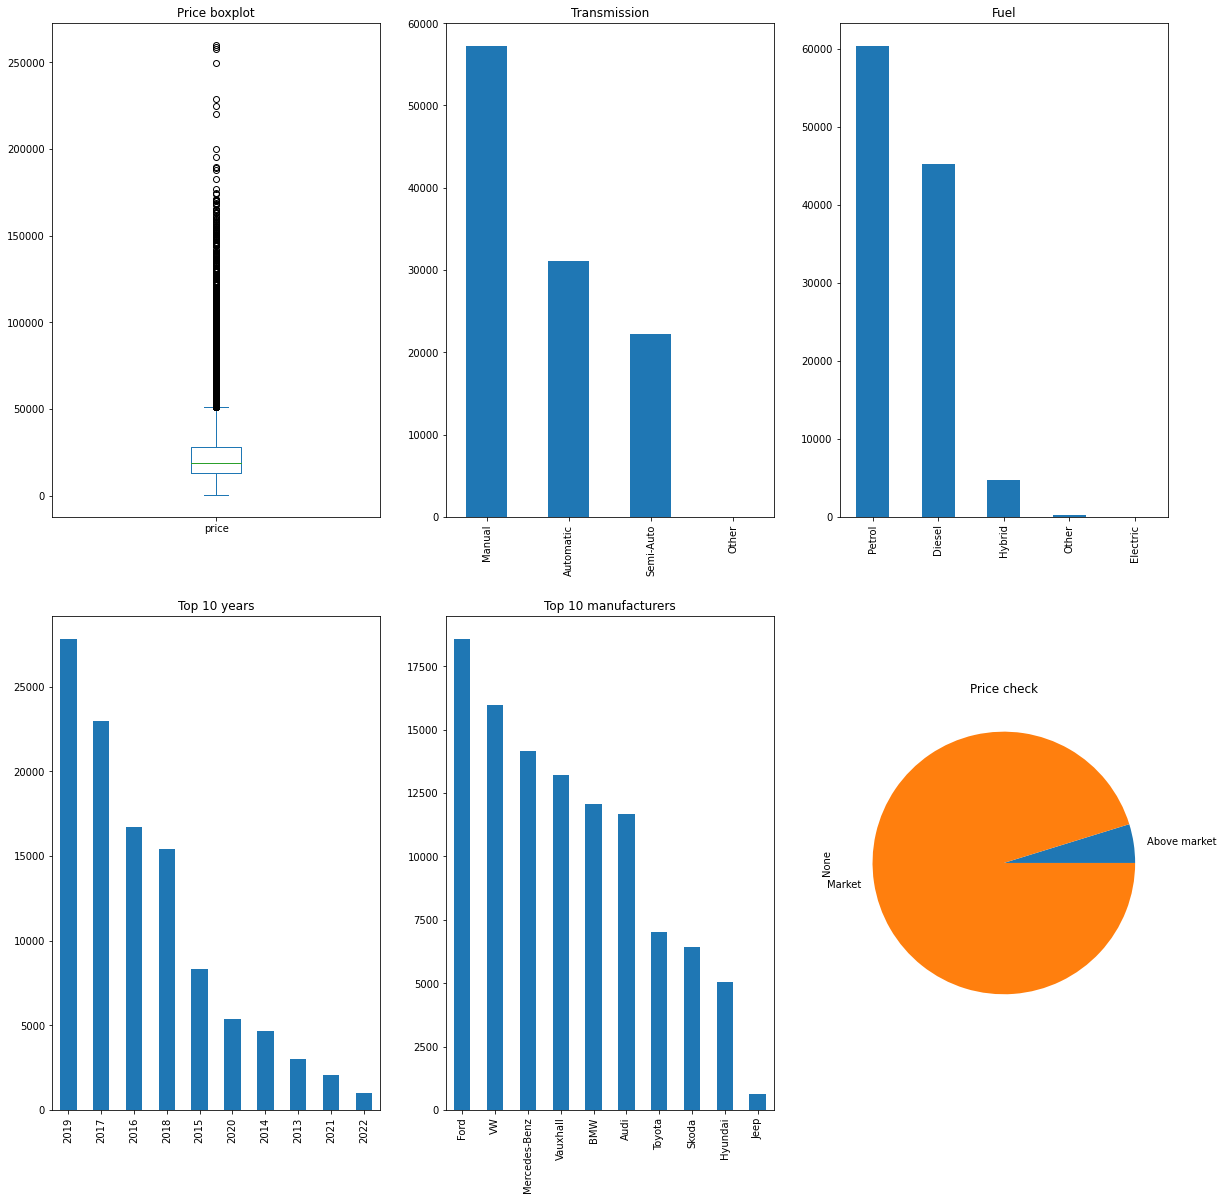

In [209]:
fig, axs = plt.subplots(2, 3, figsize=(20,20))
df.price.plot(kind='box', ax=axs[0, 0], title='Price boxplot')
df.manufacturer.value_counts()[:10].plot(kind='bar', ax=axs[1, 1], title='Top 10 manufacturers')
df.transmission.value_counts().plot(kind='bar', ax=axs[0, 1], title="Transmission")
df.fuel.value_counts().plot(kind='bar', ax=axs[0, 2], title="Fuel")
df.year.value_counts()[:10].plot(kind='bar', ax=axs[1, 0], title='Top 10 years')
df.groupby(df.price_check).size().plot(kind='pie', ax=axs[1, 2], title="Price check")

In [210]:
df_outliers = df[np.abs(stats.zscore(df.price) > 3)]
print(f'Outliers (row count = {len(df_outliers)}):')
df_outliers.head()

Outliers (row count = 2036):


,manufacturer,year,km,fuel,transmission,price,price_check
2,Audi,2021,2900.0,Hybrid,Automatic,80500.0,Market
4,Jaguar,2022,45.0,Hybrid,Automatic,73000.0,Above market
36,Porsche,2021,20900.0,Hybrid,Automatic,188000.0,Market
108,Mercedes-Benz,2016,118000.0,Petrol,Automatic,69900.0,Market
164,Porsche,2019,12500.0,Petrol,Automatic,83990.0,Market


In [211]:
print(f'Length of dataframe before outlier removal: {len(df)}')
df = df[~df.index.isin(df_outliers.index)]
print(f'Length of dataframe after outlier removal: {len(df)}')

Length of dataframe before outlier removal: 110608
Length of dataframe after outlier removal: 100926


<AxesSubplot:>

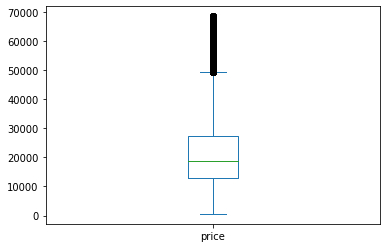

In [212]:
df.price.plot(kind = 'box')

In [219]:
df.corr()

,manufacturer,year,km,fuel,transmission,price,price_check
manufacturer,1.000000,0.029573,-0.053496,0.166279,-0.068169,-0.201232,0.007924
year,0.029573,1.000000,-0.715341,0.081714,0.081051,0.503081,0.042949
km,-0.053496,-0.715341,1.000000,-0.230452,-0.150649,-0.343587,-0.162964
fuel,0.166279,0.081714,-0.230452,1.000000,-0.048595,-0.214812,0.004614
transmission,-0.068169,0.081051,-0.150649,-0.048595,1.000000,0.052492,0.199384
price,-0.201232,0.503081,-0.343587,-0.214812,0.052492,1.000000,-0.187922
price_check,0.007924,0.042949,-0.162964,0.004614,0.199384,-0.187922,1.000000


<AxesSubplot:xlabel='year', ylabel='price'>

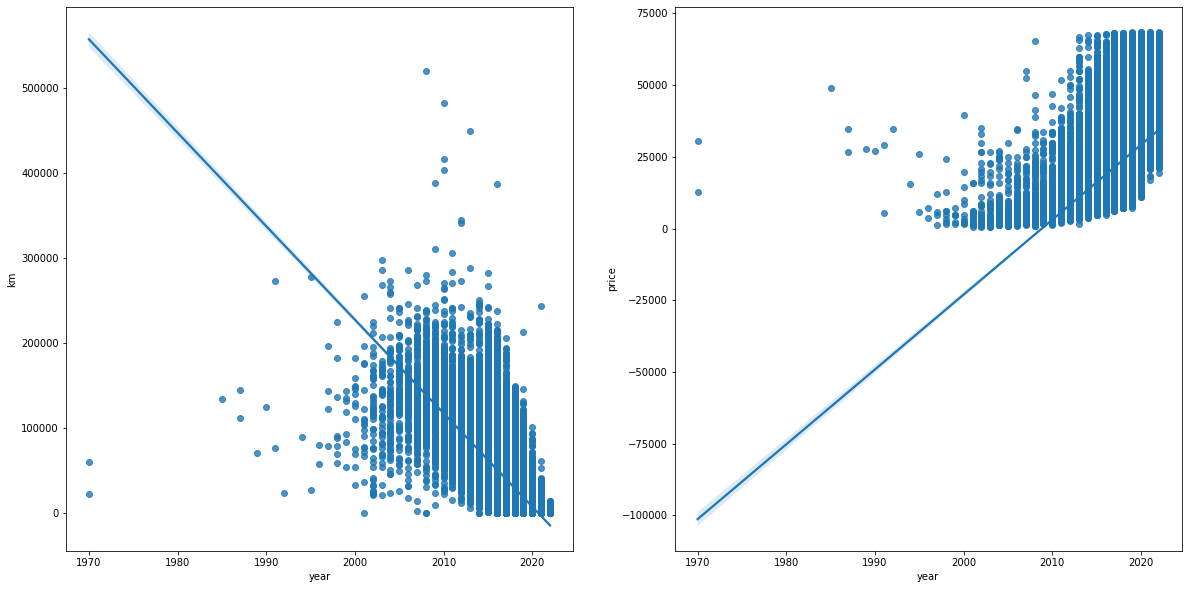

In [231]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.regplot(data=df, x='year', y='km', ax=axs[0])
sns.regplot(data=df, x='year', y='price', ax=axs[1])

## Data preparation

In [213]:
df.manufacturer = df.manufacturer.cat.codes
df.transmission = df.transmission.cat.codes
df.fuel = df.fuel.cat.codes
df.price_check = df.price_check.cat.codes

In [214]:
X = df.drop(columns='price')
y = df.price


## Price prediction

In [215]:
class BenchmarkRegressor:
    def __init__(self):
        pass

    def fit(self, X, y, **kwargs):
        self.mean = y.mean()

    def predict(self, X):
        return [self.mean] * len(X)

    def get_params(self, deep=False):
        return {}

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=21, stratify=df.price_check)

In [217]:
class BenchmarkRegressor:
    def __init__(self):
        pass

    def fit(self, X, y, **kwargs):
        self.mean = y.mean()

    def predict(self, X):
        return [self.mean] * len(X)

    def get_params(self, deep=False):
        return {}

# The following Models are currently computing used the Standard Parameters. Please keep in mind,
# that they need to be optimized using the hyperparameters within the modeling process.

bm_regr = BenchmarkRegressor()
lr_regr = LinearRegression()
ri_regr = Ridge()
br_regr = BayesianRidge()
ls_regr = Lasso()
en_regr = ElasticNet()
ne_regr = KNeighborsRegressor()
dt_regr = DecisionTreeRegressor()
rf_regr = RandomForestRegressor()
xg_regr = xgb.XGBRegressor()

models = [
    ('Benchmark', bm_regr),
    ('LR', lr_regr),
    ('Ridge', ri_regr),
    ('Bayesian Ridge', br_regr),
    ('Lasso', ls_regr),
    ('Elastic Net', en_regr),
    ('Nearest Neighbors (KNN) regression', ne_regr),
    ('Decision Tree', dt_regr),
    ('Random Forest', rf_regr),
    ('XGBoost', xg_regr),
]

In [218]:

for name, model in models:
    pipelined_model = Pipeline([
        ('pca', PCA(n_components = 4)),
        (name, model)
    ])

    # Training des Models
    pipelined_model.fit(X_train, y_train)

    # Vorhersage des trainierten models auf X_test
    y_hat = pipelined_model.predict(X_test)

    # Berechnung der verschiedenen Messwerte resp. KPI's
    EVS = (explained_variance_score(y_test, y_hat))
    ME = (max_error(y_test, y_hat))
    MAE = (mean_absolute_error(y_test, y_hat))
    MSE = np.sqrt(mean_squared_error(y_test, y_hat, squared=True))
    RMSE = np.sqrt(mean_squared_error(y_test, y_hat, squared=False))
    R2 = r2_score(y_test, y_hat)
    print('Model: ', name, ' | EVS: ', EVS)
    print('Model: ', name, ' | ME: ', ME)
    print('Model: ', name, ' | MAE: ', MAE)
    print('Model: ', name, ' | MSE ', MSE)
    print('Model: ', name, ' | RMSE ', RMSE)
    print('Model: ', name, ' | R2 ', R2)
    print('----------------')


Model:  Benchmark  | EVS:  2.220446049250313e-16
Model:  Benchmark  | ME:  46865.050083632785
Model:  Benchmark  | MAE:  9203.83118105381
Model:  Benchmark  | MSE  11867.118765214522
Model:  Benchmark  | RMSE  108.93630600132595
Model:  Benchmark  | R2  -1.739965608082983e-05
----------------
Model:  LR  | EVS:  0.35260539428333704
Model:  LR  | ME:  108367.01098882484
Model:  LR  | MAE:  7063.987081567305
Model:  LR  | MSE  9548.650554979658
Model:  LR  | RMSE  97.71719682317774
Model:  LR  | R2  0.35255783578804456
----------------
Model:  Ridge  | EVS:  0.3526053698315711
Model:  Ridge  | ME:  108366.71142428891
Model:  Ridge  | MAE:  7063.98758066183
Model:  Ridge  | MSE  9548.650733456308
Model:  Ridge  | RMSE  97.71719773640824
Model:  Ridge  | R2  0.35255781158497834
----------------
Model:  Bayesian Ridge  | EVS:  0.3526043015197168
Model:  Bayesian Ridge  | ME:  108353.689944651
Model:  Bayesian Ridge  | MAE:  7064.009275882893
Model:  Bayesian Ridge  | MSE  9548.658531612047
